In [32]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits
import seaborn as sns
from astropy.table import Table
from sklearn.neighbors import KernelDensity
import cPickle
# Note that astropy also has a modification of hist that does the same as this one.
from astroML.plotting import hist
import seaborn as sns
from astroML.density_estimation import KNeighborsDensity
from sklearn.cross_validation import KFold
from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_great_wall
from matplotlib.colors import LogNorm
%matplotlib inline

In [49]:
#Get data from SDSS
from astroML.datasets import fetch_great_wall
X = fetch_great_wall()

In [50]:
print X

[[-218.72321199  144.69926074]
 [-282.36162444  184.18611741]
 [-226.52956407  152.25774139]
 ..., 
 [-331.15986226    2.39397639]
 [-329.31015074    2.84761274]
 [-352.75009599    1.37618459]]


[]

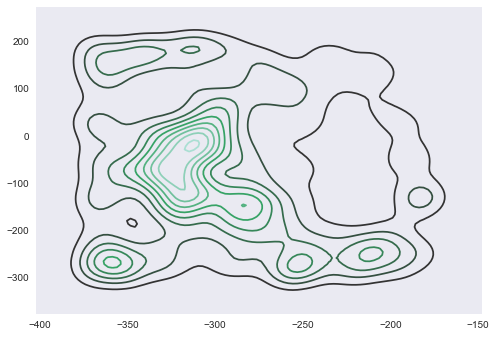

In [51]:
sns.set(style="dark")
plt.figure()
sns.kdeplot(X)
plt.plot()

In [52]:
#It is also useful to use the following to create a grid to evaluate the data on
# Create the grid on which to evaluate the results
Nx = 50
Ny = 125
xmin, xmax = (-375, -175)
ymin, ymax = (-300, 200)
xgrid = np.linspace(xmin, xmax, Nx)
ygrid = np.linspace(ymin, ymax, Ny)
mesh = np.meshgrid(xgrid, ygrid)
tmp = map(np.ravel, mesh)
Xgrid = np.vstack(tmp).T
print len(Xgrid)

6250


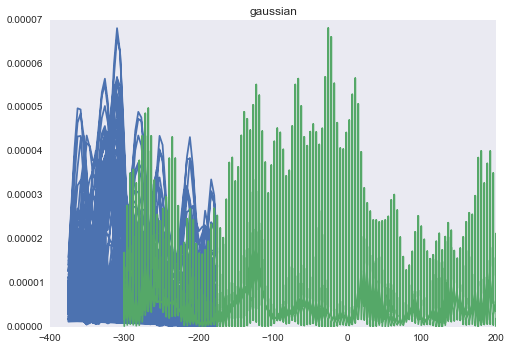

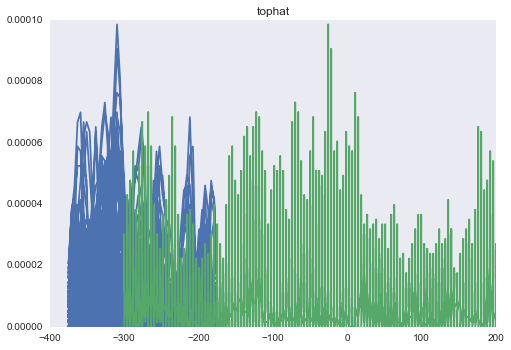

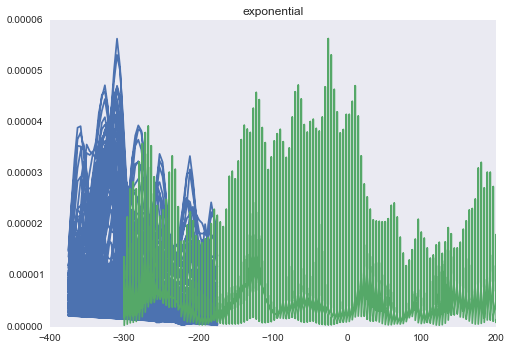

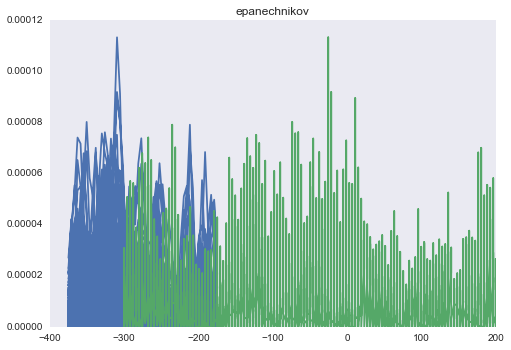

In [63]:
from sklearn.neighbors import KernelDensity

models = ['gaussian', 'tophat', 'exponential', 'epanechnikov']

for i in range(len(models)):
    plt.figure()
    kernel = KernelDensity(bandwidth=5, kernel=models[i])
    kernel.fit(X)
    dens_log  = kernel.score_samples(Xgrid)
    dens = np.exp(dens_log)
    plt.plot(Xgrid[0:], dens)
    plt.title(models[i])

In [64]:
#(b): Use 10-fold cross-validation and determine the best smoothing parameter for the great wall data
#using the kernel you preferred from a)
from astroML.density_estimation import KNeighborsDensity
from sklearn.cross_validation import KFold
from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_great_wall
from matplotlib.colors import LogNorm

def cv1(x, bws, model='gaussian', plot=False, n_folds=10):
    """
    This calculates the leave-one-out cross validation. If you set 
    plot to True, then it will show a big grid of the test and training
    samples with the KDE chosen at each step. You might need to modify the 
    code if you want a nicer layout :)
    """

    # Get the number of bandwidths to check and the number of objects
    N_bw = len(bws)
    N = len(x)
    cv_1 = np.zeros(N_bw)
    
    # If plotting is requested, set up the plot region
    if plot:
        fig, axes = plt.subplots(N_bw, np.ceil(N/n_folds), figsize=(15, 8))
        xplot = np.linspace(-3, 8, 1000)

    # Loop over each band-width and calculate the probability of the 
    # test set for this band-width
    for i, bw in enumerate(bws):
    
        # I will do N-fold CV here. This divides X into N_folds
        kf = KFold(N, n_folds=n_folds)

        # Initiate - lnP will contain the log likelihood of the test sets
        # and i_k is a counter for the folds that is used for plotting and
        # nothing else..
        lnP = 0.0
        i_k = 0
                                 
        # Loop over each fold
        for train, test in kf:
            x_train = x[train, :]
            x_test = x[test, :]
            
            # Create the kernel density model for this bandwidth and fit
            # to the training set.
            kde = KernelDensity(kernel=model, bandwidth=bw).fit(x_train)
                                 
            # score evaluates the log likelihood of a dataset given the fitted KDE.
            log_prob = kde.score(x_test)
            
            if plot:
                # Show the tries
                ax = axes[i][i_k]

                # Note that the test sample is hard to see here.
                hist(x_train, bins=10, ax=ax, color='red')
                hist(x_test, bins=10, ax=ax, color='blue')
                ax.plot(xplot, np.exp(kde.score_samples(xplot[:, np.newaxis])))
                i_k += 1
            

            lnP += log_prob
            
        # Calculate the average likelihood          
        cv_1[i] = lnP/N
        
    return cv_1

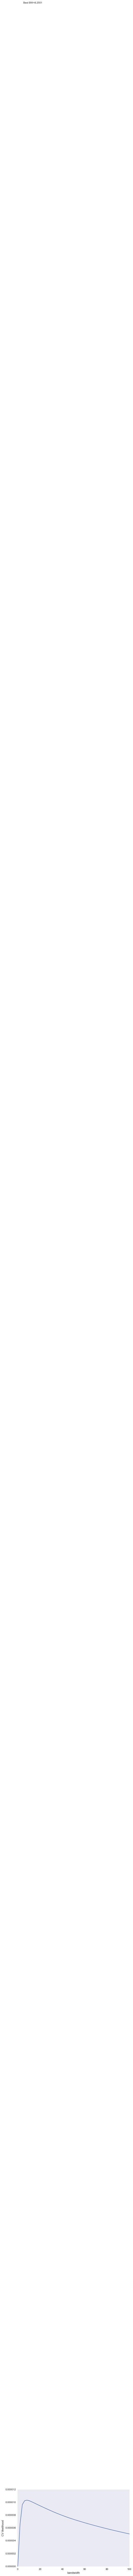

In [69]:
bws = np.linspace(0.1, 100, 50)
cv = cv1(X, bws)
#print np.exp(cv)
plt.figure()
plt.plot(bws, np.exp(cv))
plt.xlabel('bandwidth')
plt.ylabel('CV likelihood')
plt.text(5, 0.0004, 'Best BW={0:.4f}'.format(bws[np.argmax(cv)]))